# Investigating the mass metallicity relation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
%matplotlib inline

from IPython.display import display

PATH = os.path.abspath('../..')

# Same plotting and helper functions as before

In [2]:
mad = lambda x: np.median(np.abs(x - np.median(x)))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*mad(z)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [3]:
def plot_comparison_with_marginals(y_test, p_test, sz=128, which='metallicity', figname=None, annotation='', xlabel='', ylabel=''):
    
    if which == 'metallicity':
        bmin, bmax, step = 8.2, 9.3, 0.1
        if xlabel == '':
            xlabel = r'$Z_{\rm true}$'
        if ylabel == '':
            ylabel = r'$Z_{\rm pred}$'
        if sz < 8:
            max_scatter = 0.5
        else:
            max_scatter = 0.3
    elif which == 'mass':
        bmin, bmax, step = 8.4, 11.2, 0.2
        if xlabel == '':
            xlabel = r'$M_{\ast,\rm\,true}$'
        if ylabel == '':
            ylabel = r'$M_{\ast,\rm\,pred}$'
        max_scatter = 0.6
    
    gs = matplotlib.gridspec.GridSpec(20, 20)   
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    cmap = truncate_colormap(plt.cm.Greys, 0.1, 1,)
    cmap.set_bad('white', 1.)
    *_, im = ax.hist2d(y_test, p_test, bins=100, range=[[bmin, bmax], [bmin, bmax]], 
                       cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1, vmax=100, clip=True)
                      )
              
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    
    ax.text(bmin + 0.075, bmax - 1.5*step, annotation, fontsize=16)
    
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 18:19])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=16)   
    cb.ax.set_yticklabels([1] + ['']*8 + [10] + ['']*8 + [100])
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.arange(bmin, bmax, step)
    rmse_bins = np.array([np.sqrt(np.mean(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])**2)) for y in y_bins])
    num_in_bins = np.sum([(y_test > y - step/2) & (y_test < y + step/2) for y in y_bins], axis=1)
    rmse_error = np.sqrt(np.mean(((p_test - y_test)**2)))
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'RMSE = {rmse_error:.4f}')

    nmad_bins = np.array([nmad(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])) for y in y_bins])
    nmad_error = nmad(p_test - y_test)
    
    ax_marg.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'NMAD = {nmad_error:.4f}')
    
    #ax_marg.set_ylabel('Residual\nscatter', fontsize=14)
    ax_marg.set_ylabel(r'Scatter', fontsize=16)
    ax_marg.legend(fontsize=14, framealpha=0.0, frameon=False, loc='upper right')
    ax_marg.set_ylim(0, max_scatter)
    ax_marg.set_xlim(bmin, bmax)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', c='C0')
    ax_marg.axhline(nmad_error, ls='-', c='C1')

    
    # running median + std/MAD on main figure
    running_median = np.array([np.median(p_test[(y_test > y - step/2) & (y_test < y + step/2)]) for y in y_bins])
    ax.plot(y_bins, running_median, c='C3', lw=3, label='Median')
    ax.plot(y_bins, running_median + rmse_bins, c='C0', alpha=0.8, ls='--', lw=3, label=r'$\pm 1$ RMSE')
    ax.plot(y_bins, running_median - rmse_bins, c='C0', alpha=0.8, ls='--', lw=3)
    ax.plot(y_bins, running_median + nmad_bins, c='C1', alpha=0.8, ls='--', lw=3, label=r'$\pm 1$ NMAD')
    ax.plot(y_bins, running_median - nmad_bins, c='C1', alpha=0.8, ls='--', lw=3)
    
    # one-to-one line on main figure
    ax.plot([bmin, bmax], [bmin, bmax], c='k', ls='-', lw=3, zorder=1, alpha=0.8, label=r'$Z_{\rm pred} = Z_{\rm true}$')    
    
    ax.legend(loc='lower right', fontsize=14)
    
    fig.subplots_adjust(left=0.05, right=0.975, bottom=0.075, top=0.95)
    

    if not figname:
        fig.savefig(f'{PATH}/results/single-sz{sz}_{which}_pred-vs-SDSS_with-marginals.pdf', dpi=300)
    else:
        fig.savefig(figname, dpi=300)
    


# Predicting stellar mass

In [4]:
#masses = pd.read_csv(f'{PATH}/catalogs/predictions-lgm_p50.csv', index_col=0)
masses = pd.read_csv(f'{PATH}/catalogs/predictions-mass.csv', index_col=0)  # mass *only*
masses.head()

,lgm_tot_p50,cnn_lgm
objID,,
1237665128548073587,9.639243,9.521711
1237652944767550033,10.481000,11.008442
1237674477049544806,9.783792,10.008282
1237665330918850673,9.542205,9.506903
1237657630582178125,10.287520,10.373400


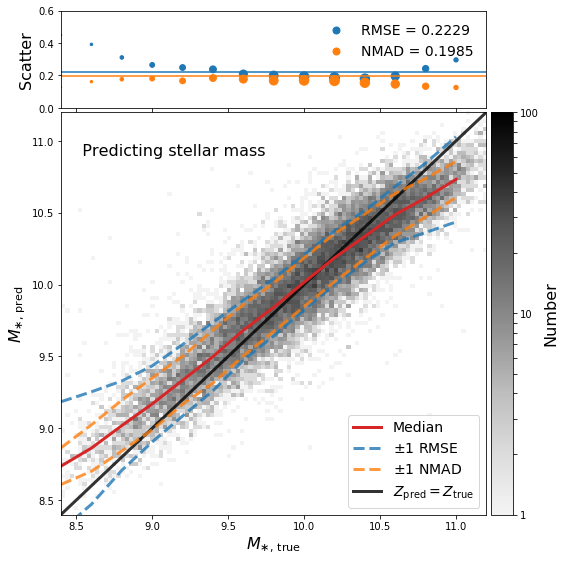

In [5]:
plot_comparison_with_marginals(masses.lgm_tot_p50.values, masses.cnn_lgm.values, which='mass',
                               annotation='  Predicting stellar mass',
                               figname=f'{PATH}/results/05-a-prediction_mass.pdf'
                              )

# Predicting $Z$ via the mass-metallicty relation

In [6]:
# tremonti et al. 2004
mmr = lambda logm: -1.492 + 1.847*logm -0.08026*logm**2


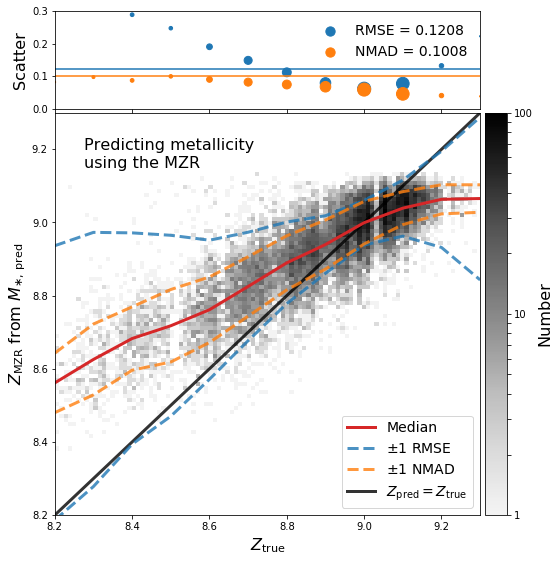

In [14]:
df = pd.read_csv(f'{PATH}/catalogs/predictions-lgm_p50.csv', index_col=0)
plot_comparison_with_marginals(df.oh_p50.values, mmr(masses.cnn_lgm.values), which='metallicity',
                               ylabel=r'$Z_{\rm MZR}$ from $M_{\ast,\rm \,pred}$', annotation='Predicting metallicity\nusing the MZR',
                               figname=f'{PATH}/results/05-b-prediction_mzr.pdf'
                              )
